# RecNet: A Deep Learning Based Collaborative Filtering Recommender System
This notebook contains all the accompanying code for the paper _RecNet: A Deep Learning Based Collaborative Filtering Recommender System_ by B. Budler and T. Packirisamy. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import preprocessing
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Baseline Collaborative Filtering Approach 

In [3]:
#read in data
ratings = pd.read_csv('ratings100k.csv')

#drop timestamp since temporal data is not used
ratings = ratings.drop('timestamp',axis =1)
ratings.head()

#encode user ids and movie ids to monotonic integers (without gaps)
user_encoder = preprocessing.LabelEncoder()
movie_encoder = preprocessing.LabelEncoder()
ratings.userId = user_encoder.fit_transform(ratings.userId.values)
ratings.movieId = movie_encoder.fit_transform(ratings.movieId.values)

#find the number of unique classes for movies and users
num_users = len(pd.value_counts(ratings.userId))
num_movies = len(pd.value_counts(ratings.movieId))

#splitting data in train, test and cross vaildation sets
train, test = train_test_split(ratings, test_size=0.2, random_state=7)
test, cv = train_test_split(test, test_size=0.5, random_state=7)


With the dataset ingested, the user_movie matrix can be created. Each user is represented by a column while each movie is represented by a row. A <code>NaN</code> value indicates a missing rating where a given movie has not yet been rated by a specific user. 

In [92]:
user_movie_matrix = ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating')
user_movie_matrix .head()

userId,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
movieId,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


We know the ratings are only in the range between 0.5-5, therefore we can treat the missing values as 0. This will not effect our Collaborative Filtering Process as the User Ratings Vectors will simply have no component in the the movie axis for a movie they have not rated yet. Because we will use the 5 most similar users to calculate the predicted rating in our baseline CF implementation, any movie which does not have _at least_ 5 ratings, will be removed from the user_movie matrix. This results in the user_movie_matrix consiting of 90 274 of the original 100 000 ratings.

In [93]:
user_movie_matrix = user_movie_matrix.dropna(thresh = 5, axis=0).fillna(0)
user_movie_matrix = user_movie_matrix.reset_index(drop=True)
print("Remaining ratings:", (user_movie_matrix>0).sum().sum())

Remaining ratings: 90274


Now we can calculate the similarity between all users using the Pearson Correlation Coefficient. The result is a square matrix of dimension $i \times i$ where $i$ representes the number of users in the dataset. The value at a specific row $n$ and a specific column $m$ is the similarity between user $n$ and user $m$.

In [94]:
user_similarity  = user_movie_matrix.corr(method="pearson")
user_similarity.head()

userId,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
userId,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.007998,0.091575,0.160236,0.108523,0.074876,0.120823,0.115943,0.051094,-0.025040,...,0.045901,0.127084,0.176396,0.037373,0.118746,0.101322,0.235721,0.218087,0.083673,0.056725
1,0.007998,1.000000,-0.005002,-0.014913,0.008247,0.004834,0.012917,0.019040,-0.007740,0.060926,...,0.204013,0.001791,-0.023487,-0.013354,-0.019310,-0.003626,-0.004911,0.011924,0.023437,0.092336
2,0.091575,-0.005002,1.000000,-0.009068,0.002348,-0.009093,-0.011268,0.002003,-0.005357,-0.010266,...,-0.000672,-0.002566,0.026964,-0.009243,0.006704,-0.000095,0.021073,0.011587,-0.005488,0.018377
3,0.160236,-0.014913,-0.009068,1.000000,0.114428,0.040390,0.082821,0.043028,-0.006971,-0.002958,...,0.058720,0.097395,0.302086,0.024029,0.048484,0.166557,0.096515,0.069953,0.016911,0.024738
4,0.108523,0.008247,0.002348,0.114428,1.000000,0.298575,0.090887,0.422368,-0.009707,0.014774,...,0.053589,0.408451,0.091260,0.255308,0.140178,0.089312,0.135896,0.101247,0.278591,0.020199


Next we will incorporate the Collaborative Filtering process. For a specific user, we iterate over each movie in the dataset. For each movie, we find the 5 users who are most similar to the active user and have rated the movie. We then calculate the predicted rating using the weighted sum of the ratings these 5 users gave the movie. 

In [95]:
# Dataframe to store the predictions 
predictions = pd.DataFrame()
predictions.rename_axis("movieId")

print("Calculating the predicted ratings for each of the 610 users:")

# Iterate over each user in the user_movie matrix
for user in user_movie_matrix.columns:
    # List to store the predicted rating of each movie for the current user
    preds = [] 
    # Print statement for debugging
    print('.', end="")

    # Iterate over each movie in the user_movie matrix 
    for movie in user_movie_matrix.index:
        # Store the entire row of rating values for the given movie 
        movie_ratings = user_movie_matrix.loc[movie,:]
        # Select only the ratings which are greater than zero (a user has actually rated the movie)
        rated_movie = movie_ratings[movie_ratings>0]
        # Select the top 5 most similar users who have rated the movie 
        similar_users  = user_similarity[user][rated_movie.index].sort_values(ascending = False)[1:6]
        
        # Calculate the sum of the most similar users similarity measures (weights) 
        weights = similar_users.sum()

        # Calculated the weighted sum of the similar users ratings to predict 
        # what the currrent user would rate the movie 
        weighted_sum = (rated_movie[similar_users.index]* similar_users).sum()
        
        # Store the predicted rating for this movie 
        preds.append(weighted_sum/weights)
    
    # Add the list of the predicted ratings of the active user for each movie 
    # to the dataframe which stores the predictions 
    predictions[user]= preds

# Display the final dataframe of predictions
predictions.head()

Calculating the predicted ratings for each of the 610 users:
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,3.758363,3.679904,4.000000,3.979508,4.400076,4.798736,4.295186,4.407581,3.396519,4.122348,...,4.158324,4.170451,4.201508,4.621577,3.987061,3.185482,4.204573,3.698741,3.764459,3.379196
1,2.302897,3.211671,3.974819,2.853281,3.592472,3.976968,2.503688,3.205857,3.798053,3.494319,...,3.192288,3.201373,2.841041,3.810151,3.606102,2.877110,3.118062,3.000824,3.562713,3.389521
2,3.189755,2.593058,2.977579,3.494658,3.519972,3.586491,2.721841,3.588523,3.410629,2.854649,...,2.964224,3.565991,3.591724,3.996979,3.216542,3.378457,2.805391,2.901861,3.754683,2.847746
3,2.744909,3.221511,-9.044633,1.745796,2.579108,2.422217,2.464053,2.715816,2.684024,1.095205,...,2.712049,2.659713,1.902718,2.355235,2.374426,2.632011,2.655079,2.686522,2.806181,1.597168
4,2.304805,2.655142,2.912732,2.538424,3.208726,3.580723,2.487629,3.000000,3.402779,2.476878,...,2.207504,3.202860,1.862195,3.759428,3.212523,2.527114,2.785295,2.670250,3.206429,2.681607


Next we determine our evaluation metric, the Root Mean Squared Error, for the baseline CF approach using the difference between the predicted ratings and the actual ratings. 

In [96]:
# List to store the individual mean squared errors for each user 
mean_squared_errors = [] 

# Iterate through each user and find the difference between the predicted ratings for movies that user 
# has rated, and the actual rating that user gave. 
for user in user_movie_matrix.columns:
    # Get list of movies the user has actually rated 
    got_rating = user_movie_matrix[user][user_movie_matrix[user]>0]
    # Get a list of the predited ratings for these movies 
    pred_rating = predictions[user][got_rating.index]
    # Find the difference between the actual rating and the predicted rating
    error = (got_rating - pred_rating)
    # Square this difference 
    squared_error = np.square(error)
    # Find the average squared differences for this user 
    mean_squared_error = squared_error.sum()/ len(got_rating)
    # Add the mean squared error for this user to the list of mean squared errors 
    mean_squared_errors.append(mean_squared_error)
    
# Calculating the mean of the mean squared error for every user yields the Mean Squared Error 
# for the baseline CF approach, taking the square root of this value yields the
# Root Mean Square Error for this approach 
mse_CF  = sum(mean_squared_errors)/len(mean_squared_errors)
rmse_CF = np.sqrt(mse_CF)
print("MSE:", mse_CF)
print("RMSE:", rmse_CF)

MSE: 1.0412980120862927
RMSE: 1.0204401070549376


## 2. Neural Colloborative Filtering (NCF)

In [5]:
#creating the dataset class according to required pytorch format
class MovieLensDataset:
    def __init__(self,userIds,movieIds,ratings):
        self.userIds = userIds
        self.movieIds = movieIds
        self.ratings = ratings
    #required for pytorch    
    def __len__(self):
        return len(self.userIds)
    
    #required for pytorch
    def __getitem__(self,item):
    #converts values into pytorch tensors and returns
        return [torch.tensor(self.userIds[item],dtype=torch.long),
                torch.tensor(self.movieIds[item],dtype=torch.long),
                torch.tensor(self.ratings[item],dtype=torch.float)]

In [6]:
#define the neural network model
#made to be customisable with layers being an nn.sequential variable
#which contains the architecture for the network
class RecNet(nn.Module):
    def __init__(self, num_users, num_movies, layers):
        super().__init__()
        
        
        #movie and user embeddings when combined make up the size of 
        #the first hidden layer given in layers
        num_embeds = int(layers[0].in_features/2)

        #embeddings 
        self.embed_movie = nn.Embedding(num_movies, num_embeds)
        self.embed_user = nn.Embedding(num_users, num_embeds) 
        
        #initialise the rest of the netwrok using layers (nn.sequential)
        self.layers = layers
    
    #forword propogation of the network
    def forward(self,userIds,movieIds,ratings = None):
        
        movie_embeds = self.embed_movie(movieIds)
        user_embeds = self.embed_user(userIds)
        
        #combine embedding vectors to be fed to multi-layer perceptron
        out = torch.cat([user_embeds,movie_embeds],dim=1)
        
        #recieve final output from multi-layer perceptron
        out = self.layers(out)
        
        #calculate Root mean squared error
        loss = torch.sqrt(nn.MSELoss()(out,ratings.view(-1,1)))
        
        return out,loss
        

In [7]:
#train network for a specified number of epochs
def train_network(epochs, model, train_loader, test_loader, calc_test = False):
    #store train and test losses each batch for plots
    train_losses = []
    test_losses = []
    
    #loop for the number of epochs
    for epoch in range(epochs):
        
        train_loss = 0
        test_loss = 0
        
        #setup model for training
        model.train()
        
        #loop through batches (recieves users, movies, ratings for each batch)
        for users, movies, ratings in train_loader:
            
            #reset the gradients accumulated for backprop from last batch
            model.zero_grad()
            
            #forward prop
            output,loss = model(users.cuda(),movies.cuda(),ratings.cuda())
            
            #backprop
            loss.backward()
            
            #update weights
            optimizer.step()
            
            #store train losses
            train_losses.append(loss.item())
            
            #store test losses
            if calc_test: 
                test_losses.append(overall_loss(model, test_loader))
                print('.',end="")
    
    #append final loss
    train_losses.append(overall_loss(model, train_loader))
    test_losses.append(overall_loss(model, test_loader))

    return train_losses, test_losses

In [8]:
#finds the root mean squared error accross a whole dataset
def overall_loss(model, data_loader):
    accumulated_loss = 0
    
    #set up model for evaluation
    model.eval()
    
    #don't calculate gradient for backprop
    with torch.no_grad():
            #loop thorugh batches
            for users, movies, ratings in data_loader:
                _,loss = model(users.cuda(),movies.cuda(),ratings.cuda())
                accumulated_loss += loss.item()
    overall_loss = accumulated_loss/len(data_loader)
    return overall_loss

In [9]:
#create objects of each dataset
training_set = MovieLensDataset(train.userId.values,train.movieId.values,train.rating.values)
    
test_set = MovieLensDataset(test.userId.values,test.movieId.values,test.rating.values)

cv_set = MovieLensDataset(cv.userId.values,cv.movieId.values,cv.rating.values)

In [10]:
#create data loaders that pytorch uses to loop through batches
batch_size= 1024

#shuffle= false since dataset is shuffled previousely
train_loader_1024 = torch.utils.data.DataLoader(dataset = training_set, batch_size = batch_size, shuffle=True)
test_loader_1024 = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle=True)
cv_loader_1024 = torch.utils.data.DataLoader(dataset = cv_set, batch_size = batch_size, shuffle=True)

## Baseline NCF Model

In [52]:
#instantiate sequential to specify nn architecture to create the model
layers = nn.Sequential(
        nn.Linear(32,32),  
        nn.ReLU(),
        nn.Linear(32,1),
        )

#instantiate model and put it on the gpu (.cuda())
model_1 = RecNet(num_users,num_movies,layers).cuda()

#instantiate the optimiser that pytorch will use
optimizer = optim.Adam(model_1.parameters(), lr=0.1)

In [53]:
#train the network
baseline_train_losses, baseline_test_losses= train_network(3, model_1, train_loader_1024, test_loader_1024,True)

.............................................................................................................................................................................................................................................

train error = 0.8007883829406545, test error = 0.9396374523639679


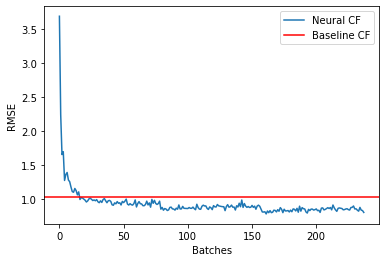

In [98]:
plt.plot(baseline_train_losses, label = "Neural CF")
plt.axhline(rmse_CF,c='red',label = "Baseline CF")
plt.xlabel('Batches')
plt.ylabel('RMSE')
plt.legend()
print(f"train error = {baseline_train_losses[-1]}, test error = {baseline_test_losses[-1]}")
plt.savefig('rmse1.png')

## Comparing architectures

This section contains a comparison between different neural network architextures with the number of layers as well as the number of units within each layer being varied.

In [55]:
layers = nn.Sequential(
        nn.Linear(32,32),  
        nn.ReLU(),
        nn.Linear(32,1),
        )
model_1 = RecNet(num_users,num_movies,layers).cuda()
optimizer = optim.Adam(model_1.parameters(), lr=0.1)

In [56]:
train_losses_1, test_losses_1 = train_network(3, model_1, train_loader_1024, cv_loader_1024,True)

.............................................................................................................................................................................................................................................

In [57]:
layers = nn.Sequential(
        nn.Linear(64,32),  
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,1)
        )
model_2 = RecNet(num_users,num_movies,layers).cuda()
optimizer = optim.Adam(model_2.parameters(), lr=0.1)

In [58]:
train_losses_2, test_losses_2 = train_network(3, model_2, train_loader_1024, cv_loader_1024,True)

.............................................................................................................................................................................................................................................

In [59]:
layers = nn.Sequential(
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,1),
        )
model_3 = RecNet(num_users,num_movies,layers).cuda()
optimizer = optim.Adam(model_3.parameters(), lr=0.1)

In [60]:
train_losses_3, test_losses_3 = train_network(3, model_3, train_loader_1024, cv_loader_1024,True)

.............................................................................................................................................................................................................................................

In [61]:
layers = nn.Sequential(
        nn.Linear(64,64),
          nn.ReLU(),
          nn.Linear(64,64),
          nn.ReLU(),
          nn.Linear(64,64),
          nn.ReLU(),
          nn.Linear(64,1),
        )
model_4 = RecNet(num_users,num_movies,layers).cuda()
optimizer = optim.Adam(model_4.parameters(), lr=0.1)

In [62]:
train_losses_4, test_losses_4 = train_network(3, model_4, train_loader_1024, cv_loader_1024, True)

.............................................................................................................................................................................................................................................

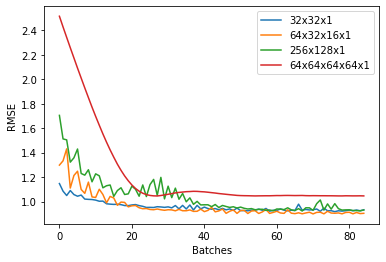

final costs:
32x32x1: train = 0.7871228977094723, test = 0.907213443517685
64x32x16x1: train = 0.7640224770654606, test = 0.9060243546962738
256x128x1: train = 0.808436575569684, test = 0.9200530588626862
64x64x64x1: train = 1.0409186452249937, test = 1.0464345455169677


In [63]:
#plot decreasing errors for all proposed architectures
plt.plot(test_losses_1[15:100], label='32x32x1')
plt.plot(test_losses_2[15:100], label='64x32x16x1')
plt.plot(test_losses_3[15:100], label='256x128x1')
plt.plot(test_losses_4[15:100], label='64x64x64x64x1')
plt.xlabel('Batches')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()
print('final costs:')
print(f'32x32x1: train = {train_losses_1[-1]}, test = {test_losses_1[-1]}')
print(f'64x32x16x1: train = {train_losses_2[-1]}, test = {test_losses_2[-1]}')
print(f'256x128x1: train = {train_losses_3[-1]}, test = {test_losses_3[-1]}')
print(f'64x64x64x1: train = {train_losses_4[-1]}, test = {test_losses_4[-1]}')

It can be seen that the best performing architecture on both the train and test set is a telescoping architecture in which there is an embedding layer of 64 units which is fed into a subsequent Multi-Layer Perceptron of the architecture 64x32x16x1. 

### Hyperparameter Tuning

This section finds optimal values for hyperparameters within the network. The best architecture found previousely will be used as the baseline for comparisons.

training:  256
training:  1024
training:  4096
training:  10240
{'256': 0.9187321439385414, '1024': 0.9017812192440033, '4096': 0.9789913892745972, '10240': 1.1397658586502075}


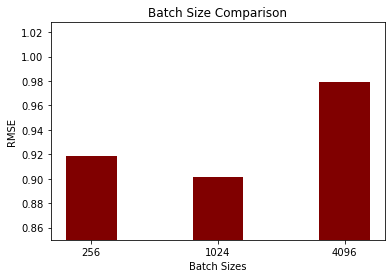

In [64]:
#set up all batch sizes that will be tested
batch_sizes = [ 256, 1024, 4096,10240]

#will store overall loss for each batch_size
batches_loss = {}

#loop through batch_sizes
for current_batch_size in batch_sizes:
    print('training: ',current_batch_size)
    
    #create data_loaders for given batch
    train_loader = torch.utils.data.DataLoader(dataset = training_set, batch_size = current_batch_size, shuffle=True)
    cv_loader = torch.utils.data.DataLoader(dataset = cv_set, batch_size = current_batch_size, shuffle=True)
    
    layers = nn.Sequential(
        nn.Linear(64,32),  
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,1)
        )
    model_ = RecNet(num_users,num_movies,layers).cuda()
    optimizer = optim.Adam(model_.parameters(), lr=0.1)
    
    train_losses, cv_losses = train_network(1, model_, train_loader, cv_loader)

    batches_loss[f"{current_batch_size}"] = cv_losses[-1] 
print(batches_loss)

#remove batch size = 10240 since cost is too high. warps graph
batches_loss.pop('10240')
batches = list(batches_loss.keys())
vals = list(batches_loss.values())

fig1, ax1 = plt.subplots()


ax1.bar(batches,vals , color ='maroon', width = 0.4)
plt.title('Batch Size Comparison')
plt.xlabel('Batch Sizes')
plt.ylabel('RMSE')
ax1.set_ylim(bottom=0.85)
plt.show()

It can be seen that a batch size of 1024 provides the best final cost after training and is therefore the ideal choice for batch size when training 

training:  0.001
training:  0.01
training:  0.1
{0.001: 2.1153454780578613, 0.01: 0.9608966708183289, 0.1: 0.9148385047912597}


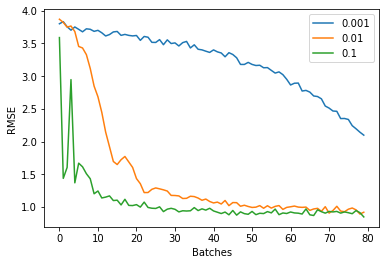

In [11]:
#set up all learning rates that will be tested
learning_rates = [0.001,0.01,0.1]

#will store overall loss for each learning rate
lr_losses = {}

#loop through learning rates
for learning_rate in learning_rates:
    print('training: ',learning_rate)
    
    layers = nn.Sequential(
        nn.Linear(64,32),  
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,1)
        )
    
    model_ = RecNet(num_users,num_movies,layers).cuda()
    optimizer = optim.Adam(model_.parameters(), lr=learning_rate)
    
    train_losses, cv_losses = train_network(1, model_, train_loader_1024, cv_loader_1024)

    lr_losses[learning_rate] = cv_losses[-1]
    
    #plot errors reducing with each learning rate
    plt.plot(train_losses, label = learning_rate)

print(lr_losses)
plt.xlabel('Batches')
plt.ylabel('RMSE')
plt.legend()
plt.show()

It can be seen in the graph above that the learning rate that converges the fastest and to the lowest point is 0.1. This will threfore be used for the final model

### Regularisation

It can be seen that the best architecture found previously has a relatively large split between train and test error. This is indicative of overfitting and therefore regularisation techniques may be useful. The following section goes on to test 2 regularisation techniques, namely L2 regularisation and drop out.

In [66]:
#no regularisation
layers = nn.Sequential(
        nn.Linear(64,32),  
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,1)
        )
baseline = RecNet(num_users,num_movies,layers).cuda()
optimizer = optim.Adam(baseline.parameters(), lr=0.1)

In [67]:
un_reg_train_losses, un_reg_test_losses = train_network(3, baseline, train_loader_1024, cv_loader_1024,True)

.............................................................................................................................................................................................................................................

In [80]:
#dropout
layers = nn.Sequential(
        nn.Linear(64,32), 
        nn.ReLU(),
        nn.Dropout(0.6),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Dropout(0.6),
        nn.Linear(16,1)
        )
do_model = RecNet(num_users,num_movies,layers).cuda()
optimizer = optim.Adam(do_model.parameters(), lr=0.1)

In [81]:
do_train_losses, do_test_losses = train_network(3, do_model, train_loader_1024,cv_loader_1024,True)

.............................................................................................................................................................................................................................................

In [70]:
#L2 regularisation (weight_decay variable in optimiser)
layers = nn.Sequential(
        nn.Linear(64,32),  
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,1)
        )
reg_model = RecNet(num_users,num_movies,layers).cuda()
optimizer = optim.Adam(reg_model.parameters(), lr=0.1, weight_decay = 0.001)

In [71]:
reg_train_losses, reg_test_losses = train_network(3, reg_model, train_loader_1024, cv_loader_1024,True)

.............................................................................................................................................................................................................................................

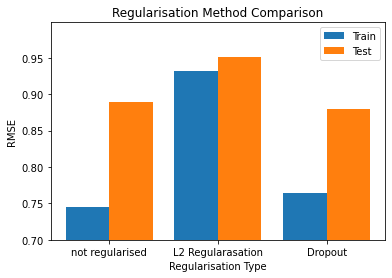

In [82]:
fig2, ax2 = plt.subplots()

y_tests = [un_reg_test_losses[-1],reg_test_losses[-1],do_test_losses[-1]]
y_trains =  [un_reg_train_losses[-1],reg_train_losses[-1],do_train_losses[-1]]

x = ['not regularised','L2 Regularasation','Dropout']
X_axis = np.arange(3)
ax2.bar(X_axis - 0.2, y_trains, 0.4, label = 'Train')
ax2.bar(X_axis + 0.2, y_tests, 0.4, label = 'Test')
plt.xticks(X_axis, x)
plt.title('Regularisation Method Comparison')
plt.xlabel('Regularisation Type')
plt.ylabel('RMSE')
ax2.set_ylim(bottom=0.7)
plt.legend()
plt.show()

It can be seen that the non-regularised baseline has a large gap between error on the training set and error on the test set. It can be seen that L2 regularisation reduces the overfitting but increase both train and test error. It is therefore not a suitable solution. Dropout on the other hand decreases overfitting and at the same time brings down the test error. It is therefore deided that the final model will incorporate dropout

### Final Model

In [83]:
layers = nn.Sequential(
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Dropout(0.6),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Dropout(0.6),
        nn.Linear(16,1)
        )
final_model = RecNet(num_users,num_movies,layers).cuda()
optimizer = optim.Adam(final_model.parameters(), lr=0.1)

final_train_losses, final_test_losses = train_network(3, final_model, train_loader_1024, test_loader_1024,True)

.............................................................................................................................................................................................................................................

original model train error = 0.8007883829406545, original model test error = 0.9396374523639679
final train error = 0.7673668280432496,final test error = 0.8976085186004639


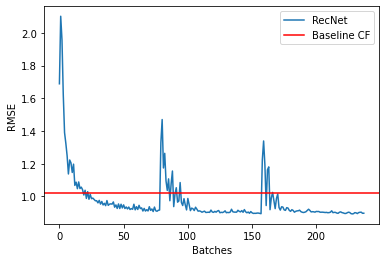

In [101]:
plt.plot(final_test_losses, label = "RecNet")
plt.axhline(rmse_CF,c='red',label = "Baseline CF")
plt.xlabel('Batches')
plt.ylabel('RMSE')
plt.legend()

plt.savefig('rmse1.png')
print(f"original model train error = {baseline_train_losses[-1]}, original model test error = {baseline_test_losses[-1]}")
print(f"final train error = {final_train_losses[-1]},final test error = {final_test_losses[-1]}")

It can be seen that various improvements to the baseline method have led to a reduced test error and therefore a better recommender system. The system signifcantly outperforms the baseline traditional Collaborative Filtering Techniques.